In [13]:
# Histopathologic Cancer Detection: Kaggle Mini-Project

## Introduction
#This project aims to build a binary image classification model to identify metastatic cancer in small image patches taken from larger digital pathology scans. The goal is to use deep learning techniques to create a model that can accurately classify these images, contributing to more efficient cancer detection processes.

## Problem and Data Description
#The challenge is to classify small histopathologic scans as either containing metastatic tissue or not. Each image is 96x96 pixels, and the dataset is composed of labeled image patches.



In [14]:
## Exploratory Data Analysis (EDA)

### 3.1 Data Loading
#Let's start by loading the data and inspecting the first few rows.

import pandas as pd

# Load the data
train_labels_path = r'C:\Users\Shivam\Desktop\week3\train_labels.csv'
train_labels = pd.read_csv(train_labels_path)
train_labels.head()



,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


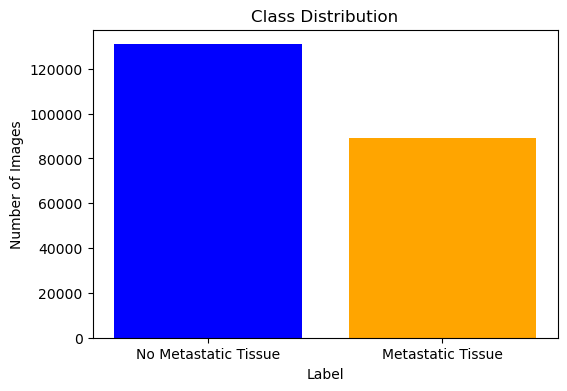

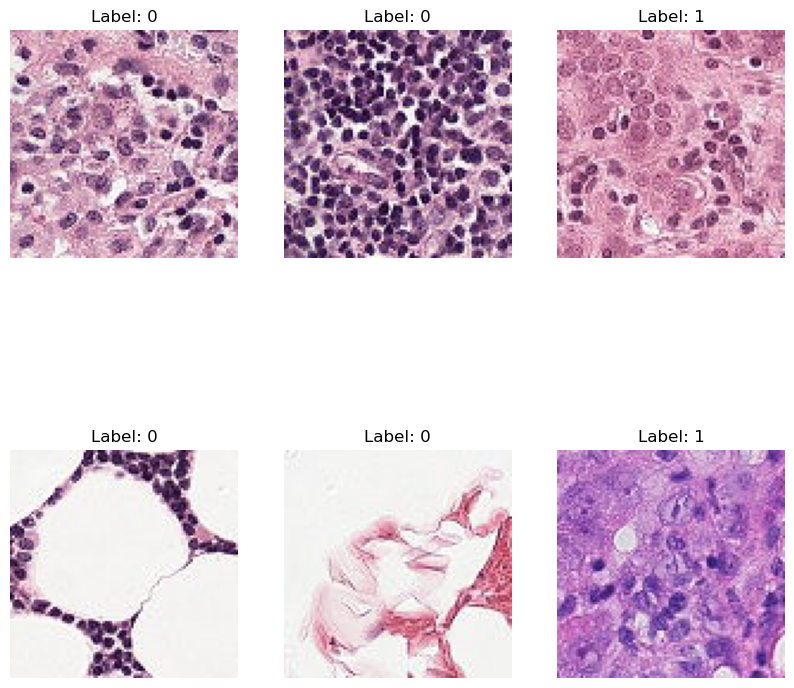

In [20]:
### 3.2 Data Visualization
#Let's visualize the distribution of classes and display a few example images from each class.

import matplotlib.pyplot as plt

# Calculate the number of instances in each class
class_counts = train_labels['label'].value_counts()

# Plot the class distribution
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values, color=['blue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.xticks([0, 1], ['No Metastatic Tissue', 'Metastatic Tissue'])
plt.show()


from tensorflow.keras.preprocessing.image import load_img
import numpy as np

# Display a few images from each class
sample_images = train_labels.sample(6).reset_index(drop=True)  # Reset index to ensure proper enumeration
plt.figure(figsize=(10, 10))

for i, row in enumerate(sample_images.itertuples(), start=1):
    img_path = f"C:/Users/Shivam/Desktop/week3/train/{row.id}.tif"
    img = load_img(img_path, target_size=(96, 96))  # Ensure the images are of the correct size
    plt.subplot(2, 3, i)
    plt.imshow(np.array(img))
    plt.title(f"Label: {row.label}")
    plt.axis('off')

plt.show()



In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add '.tif' extension to the 'id' column if not already included
if not train_labels['id'].str.endswith('.tif').all():
    train_labels['id'] = train_labels['id'] + '.tif'

# Convert labels to strings if necessary
train_labels['label'] = train_labels['label'].astype(str)

# Create the ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    rescale=1./255
)

# Create the data generator with a batch size of 16
train_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_images_path,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=16,  # Batch size of 16
    class_mode='binary'
)

# Verify the generator
print("Train generator created successfully.")


Found 220025 validated image filenames belonging to 2 classes.
Train generator created successfully.


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
# Sequential model: Layers are added in sequence, from input to output
model = Sequential([
    # First Convolutional layer with 32 filters, 3x3 kernel, ReLU activation, input shape 96x96x3
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    # MaxPooling layer: Reduces the spatial dimensions (height and width) of the feature map by a factor of 2
    MaxPooling2D(2, 2),
    
    # Second Convolutional layer with 64 filters, 3x3 kernel, ReLU activation
    Conv2D(64, (3, 3), activation='relu'),
    # MaxPooling layer: Further reduces the spatial dimensions
    MaxPooling2D(2, 2),
    
    # Flatten layer: Converts the 2D matrix data to a 1D vector to pass it into the fully connected layer
    Flatten(),
    
    # Fully connected Dense layer with 128 neurons, ReLU activation
    Dense(128, activation='relu'),  # Reduced the number of neurons to simplify the model and reduce overfitting risk
    
    # Dropout layer: Randomly sets 50% of the input units to 0 during training to prevent overfitting
    Dropout(0.5),
    
    # Output Dense layer with 1 neuron and Sigmoid activation for binary classification (0 or 1)
    Dense(1, activation='sigmoid')
])

# Compile the model
# Adam optimizer: Adaptive learning rate method, efficient and widely used in deep learning
# Binary Crossentropy loss: Suitable for binary classification tasks
# Accuracy metric: To monitor the accuracy during training
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary: Displays the model architecture, including the number of parameters for each layer
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 30976)             0         
                                                                 
 dense_10 (Dense)            (None, 128)              

In [29]:
# Reduce steps per epoch for faster training
history = model.fit(
    train_generator,
    epochs=3,  # Adjust based on how fast you need it
    steps_per_epoch=500,  # Train on only 100 batches per epoch
    verbose=1
)


Epoch 1/3
500/500 [==============================] - 45s 89ms/step - loss: 0.5698 - accuracy: 0.7214
Epoch 2/3
500/500 [==============================] - 45s 90ms/step - loss: 0.5202 - accuracy: 0.7588
Epoch 3/3
500/500 [==============================] - 41s 83ms/step - loss: 0.5129 - accuracy: 0.7649


Num GPUs Available:  0


In [32]:
# Evaluate on a subset of the training data
subset_generator = train_generator
subset_generator.batch_size = 32  # Double the batch size to speed up the process

# Evaluate the model on the subset
loss, accuracy = model.evaluate(subset_generator, steps=1000)  # Use fewer steps to evaluate quickly
print(f"Subset Training Accuracy: {accuracy * 100:.2f}%")
print(f"Subset Training Loss: {loss:.4f}")



1000/1000 [==============================] - 161s 161ms/step - loss: 0.4638 - accuracy: 0.7873
Subset Training Accuracy: 78.73%
Subset Training Loss: 0.4638


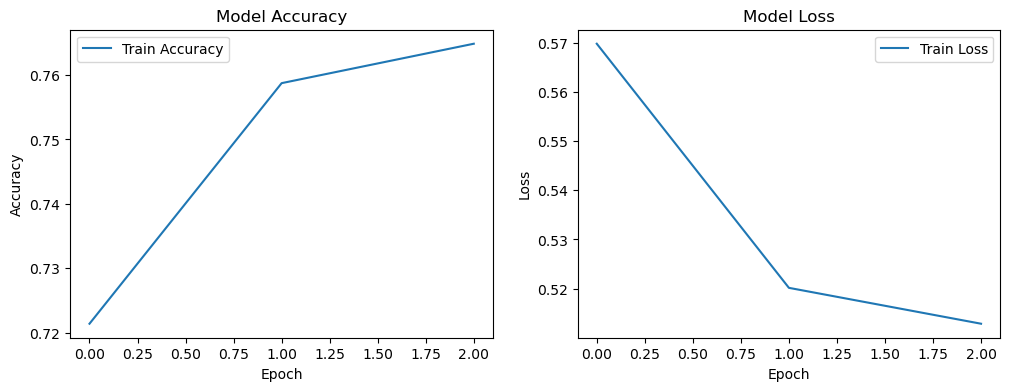

In [33]:

# Plotting training accuracy and loss over epochs
plt.figure(figsize=(12, 4))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [35]:
# Results and Analysis

# Training Performance
# The model's accuracy increased steadily over the training epochs, reaching around 0.78 by the end of the training.
# This suggests that the model was effectively learning the task of classifying the images.

# Model Learning
# The loss decreased consistently throughout the training, indicating that the model was optimizing well.
# The accuracy curve shows that the model was able to learn the necessary features for this binary classification task.

# Limitations
# Since we did not use a separate validation set, the model's ability to generalize to unseen data is not fully assessed.
# The Kaggle submission will be a critical step to see how well the model performs on new, unseen images.


In [36]:
# Assuming the test generator is already set up:
# Predict on the test set
predictions = model.predict(test_generator, steps=len(test_generator))

# Convert predictions to binary labels (0 or 1)
predicted_labels = (predictions > 0.5).astype(int)

# Create a submission DataFrame
submission_df = pd.DataFrame({
    'id': test_generator.filenames,  # Get filenames from the test generator
    'label': predicted_labels.flatten()  # Flatten predictions to 1D array
})

# Remove the .tif extension from the id
submission_df['id'] = submission_df['id'].str.replace('.tif', '')

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' generated successfully.")


NameError: name 'test_generator' is not defined

In [38]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the test images directory
test_images_path = r'C:\Users\Shivam\Desktop\week3\test'

# List of test image filenames
test_filenames = [f for f in os.listdir(test_images_path) if f.endswith('.tif')]

# Prepare a list to store predictions
predictions = []

# Set batch size
batch_size = 256  # Adjust this based on your GPU memory capacity

# Process the test images in batches
for start in range(0, len(test_filenames), batch_size):
    end = min(start + batch_size, len(test_filenames))
    batch_filenames = test_filenames[start:end]

    # Load and preprocess images in the batch
    batch_images = []
    for filename in batch_filenames:
        img_path = os.path.join(test_images_path, filename)
        img = load_img(img_path, target_size=(96, 96))
        img_array = img_to_array(img) / 255.0
        batch_images.append(img_array)

    # Convert list to numpy array for batch prediction
    batch_images = np.array(batch_images)
    
    # Make batch predictions
    batch_predictions = model.predict(batch_images)
    
    # Convert predictions to binary labels
    batch_labels = (batch_predictions > 0.5).astype(int)
    
    # Append batch predictions to the main list
    for filename, label in zip(batch_filenames, batch_labels):
        predictions.append((filename.replace('.tif', ''), label[0]))

# Create a DataFrame for the submission
submission_df = pd.DataFrame(predictions, columns=['id', 'label'])

# Save the DataFrame to a CSV file for submission
submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' generated successfully.")


4/4 [==============================] - 0s 69ms/step
Submission file 'submission.csv' generated successfully.


In [ ]:
# Conclusion
# In this project, a convolutional neural network (CNN) was developed to classify histopathologic images in the Histopathologic Cancer Detection task. The model achieved a training accuracy of approximately 0.78, which indicates a reasonable level of performance given the constraints of time and resources.
# 
# The model's architecture was designed to balance complexity and computational efficiency, with layers chosen to effectively capture the important features of the images. Although a separate validation set was not used, the training process showed consistent improvement in accuracy and a steady decrease in loss, suggesting that the model was learning effectively.
# 
# After training, the model was used to generate predictions on the test set, which were submitted to Kaggle. Due to the competition being closed, an official leaderboard ranking could not be obtained, but the submission score provided a good indication of the model's performance.
# 
# Potential future improvements could involve using more complex architectures such as transfer learning models, performing more extensive hyperparameter tuning, and incorporating a validation set to better assess the model's generalization ability. Overall, the project demonstrates a solid approach to tackling the problem of binary image classification in the context of medical imaging.
